In [1]:
import os
import sys
sys.path.append('..')
from collections import defaultdict

from siamese.dataprep import SiamesePairedDataset
from siamese.networks import SiameseNetwork

import PIL
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

import fastai
from fastai.vision import *

from tqdm import tqdm_notebook

### Oxford-IIIT Pets Dataset
The pets dataset was assembled in 2012 by researchers at the University of Oxford in the UK and the International Institute of Information Technology in Hyderabad, India. It consists of 7,349 images of 25 cat and 12 dog breeds (37 total breeds), with about 200 images from each breed. There are associated annotations for the images, including labels as well as bounding boxes for object localization studies.

The data set can be found here: [Oxford-IIIT Pets Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

To easily pull it locally, run the following, which will create a directory `data` in the `nbs` folder:

In [3]:
!mkdir data
!wget -P data https://www.robots.ox.ac.uk/\~vgg/data/pets/data/images.tar.gz
!wget -P data https://www.robots.ox.ac.uk/\~vgg/data/pets/data/annotations.tar.gz

mkdir: cannot create directory ‘data’: File exists
--2021-07-13 12:58:29--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘data/images.tar.gz.1’

images.tar.gz.1     100%[===================>] 755.23M  16.1MB/s    in 47s     

2021-07-13 12:59:17 (15.9 MB/s) - ‘data/images.tar.gz.1’ saved [791918971/791918971]

--2021-07-13 12:59:17--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘data/annotations.tar.gz.1’

annotations.tar.gz. 100%[===========

In [4]:
!tar -xf data/images.tar.gz -C data
!tar -xf data/annotations.tar.gz -C data

In addition to the `tar.gz` files, you should see two folders: `images` and `annotations`. `images` contains all the image files in `.jpg` format. 

`annotations` contains several files:

- `list.txt`: Each row identifies the image name, class id (breed), whether the image is a cat or dog, and the breed id within the cats/dogs class.
- `trainval.txt` and `test.txt`: Pre-determined 50% splits of the training data into a dataset for training+validation runs, and then a 50% holdout set for testing.
- `xmls`: Location annotation for tight bounding box around the pet head, for object localization work.
- `trimaps`: Pixel level foreground/background masks for object segmentation work.

### Load / prepare file and class definitions

In [2]:
# The base directory location where the image and annotation folders live
BASE_DATA_PATH = './data'

# Load in the space-delimited CSV file, skipping leading comment rows and adding column names
data = pd.read_csv(f'{BASE_DATA_PATH}/annotations/list.txt', 
                   header=None, 
                   skiprows=6, 
                   delimiter=' ',
                   names=['image', 'label', 'species', 'breed'])

In [3]:
data.shape

(7349, 4)

In [4]:
data.head()

,image,label,species,breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


We'll be using our custom SiameseDataset class in order to load paired image samples for our Siamese neural network. In order to load in the images, it needs a pandas DataFrame with two columsn: 1) the full path for all images, 2) the class label for each image.

The `image` column in  `data` needs the full path and image extension (`.jpg` for all our images) added.

In [5]:
data['image'] = data['image'].map(lambda image_name: os.path.join(BASE_DATA_PATH, 'images', f'{image_name}.jpg'))

In [6]:
data.head()

,image,label,species,breed
0,../../data/images/Abyssinian_100.jpg,1,1,1
1,../../data/images/Abyssinian_101.jpg,1,1,1
2,../../data/images/Abyssinian_102.jpg,1,1,1
3,../../data/images/Abyssinian_103.jpg,1,1,1
4,../../data/images/Abyssinian_104.jpg,1,1,1


### Create train/validation sets

We'll use the scikit learn `train_test_split` function to divide our data into a training and validation set, using the class label column for stratification to ensure we get the proper proportional representation of each class in the respective datasets.

In [7]:
train_df, val_df = train_test_split(data, stratify=data['label'], test_size=0.25)

The dataset is fairly small, so as usual we'll want to apply some image augmentation techniques to reduce overfitting. `pytorch` transforms take care of this, as well as forcing the images into a standard size and format. We map the pixel values of the images to be in the range `[-1,1]`, which is the range used for the pre-trained ResNets we'll be using below.

We separate the `train` and `validation` transforms, since we don't need to apply the random augmentation transformations for the `validation` set during inference. Here we do not use test-time augmentation.

In [8]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - 0.5) / 0.5)
])

transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - 0.5) / 0.5)
])

Create the `pytorch` `Dataset` objects. Here we use the default uniform sampling, where each class is equally likely to be sampled, regardless of the relative class frequency.

In [9]:
train_dataset = SiamesePairedDataset(train_df,
                                     path_col='image',
                                     label_col='label',
                                     transform=transform_train)

val_dataset = SiamesePairedDataset(val_df,
                                   path_col='image',
                                   label_col='label',
                                   transform=transform_val)

In [10]:
# User adjustable mini-batch size for mini-batch stochastic gradient descent
batch_size = 64

# Use the GPU as the main device
device = torch.device(0)

def get_model_learner():
    # Appropriate splits for ResNet models, used to apply different learning rates
    # to different layers through the fastai API
    split_dict = {'resnet18': [26, 50],'resnet34': [41, 90], 'resnet50': [57, 124]}

    # Initialize the Siamese neural network, using a pretrained ResNet as the
    # the image feature extractor. A randomly initialized fully connected layer 
    # is added to determine the image similarity
    model_ft = SiameseNetwork(models.resnet34(pretrained=True))

    # Initialize the fastai vision DataBunch, which helps distribute
    # the model data to the GPU for the learner
    databunch = DataBunch.create(train_dataset, 
                                 val_dataset, 
                                 bs=batch_size, 
                                 device=device, 
                                 num_workers=8)

    # Set the training criterion, usually CrossEntropy for the way we have
    # the Siamese network set up with binary outputs indicating similar/dissimilar
    criterion = nn.CrossEntropyLoss()

    # Initialize the fastai learner, which helps coordinate model training, taking
    # care of many of the low level details for us
    learn = Learner(databunch, 
                    model_ft, 
                    loss_func=criterion, 
                    metrics=accuracy, 
                    layer_groups=split_model_idx(model_ft, split_dict['resnet34']))
    
    return learn

learn = get_model_learner()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/chris/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

### Train the neural network

For this first experiment we separated the dataset's images into the train and validation sets. For both datasets, all classes are represented, meaning each breed is in both the training and the validation sets.

First we'll use the `fastai` learning rate finder, which begins training a single epoch for the network while stepping through increasing learning rates. This is used to determine an appropriate learning rate for the network and dataset, as described in Leslie Smith's 2015 work [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf]).

In [11]:
learn.lr_find()

/home/chris/apps/miniconda3/envs/siamese/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


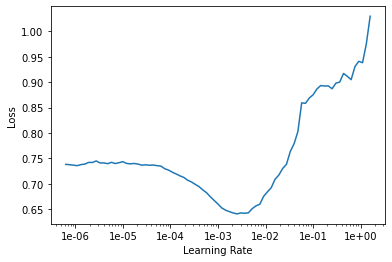

In [12]:
learn.recorder.plot()

From this plot, we can see that a learning rate of `1e-3` is probably an appropriate place to train our network. We apply the one-cycle policy discussed in Leslie Smith's 2018 work [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, momentum, and weight decay](https://arxiv.org/abs/1803.09820).

In [13]:
lr = 1e-3
learn.fit_one_cycle(10, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.634686,0.546201,0.726877,00:25
1,0.387329,0.267140,0.909684,00:26
2,0.255543,0.193912,0.940152,00:26
3,0.210447,0.179709,0.929271,00:26
4,0.182956,0.195359,0.928183,00:26
5,0.152319,0.131363,0.955930,00:26
6,0.127392,0.149276,0.949401,00:26
7,0.121613,0.135203,0.950490,00:26
8,0.105883,0.133211,0.955386,00:26
9,0.102231,0.110639,0.960827,00:26


### Train the neural network, holding out a set of classes

One of the major applications of Siamese neural networks is for one-shot learning. Here, a network is trained to learn when images are similar/dissimilar. For example, we train the network with a dataset consisting of many types of balls (basketball, baseball, raquetball, etc.). After training, we want to take a single image of a new type of ball (say it's never seen a tennis ball before), and use that to identify other tennis balls in new image data. 

This type of one-shot learning is very interesting for applications like facial recognition. Think about Apple's FaceID. It takes a few shots of your face from various angles, and from then on it can determine if new face images taken during the authentication process are you or someone else attempting to access your phone. Apple likely uses some sort of Siamese network underneath the hood to accomplish this, using a trained network to infer whether or not the new image is the phone's owner.

In the training above, we haven't _quite_ tested this idea. We mixed in all the image classes together in both the training and validation sets. We didn't hold out our tennis ball during training, so the network had already seen tennis balls, and should have an easier time identifying images similar to a reference tennis ball image. We don't know if it's really learned general features that make ball types similar, or if it's memorized very specific features of each class.

Let's try the same training, except we'll create our training and validation datasets from completely different classes, and test how well the network is learning to identify similar cat/dog breeds that it hasn't seen before.

In [14]:
# Extract the unique set of classes
classes = data['label'].unique()

# Randomly choose 2/3 of the breeds (25) for the train set, the rest are the validation set
train_classes = np.random.choice(classes, size=25, replace=False)
val_classes   = set(classes) - set(train_classes)

In [15]:
# Seprate the train and validation parts of our data
train_df = data[data['label'].map(lambda x: x in train_classes)]
val_df   = data[data['label'].map(lambda x: x in val_classes)]

In [16]:
train_df.shape, val_df.shape, data.shape,

((4974, 4), (2375, 4), (7349, 4))

Now we can carry through with the rest of our training as before.

In [17]:
train_dataset = SiamesePairedDataset(train_df,
                                     path_col='image',
                                     label_col='label',
                                     transform=transform_train)

val_dataset = SiamesePairedDataset(val_df,
                                   path_col='image',
                                   label_col='label',
                                   transform=transform_val)

In [18]:
learn = get_model_learner()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


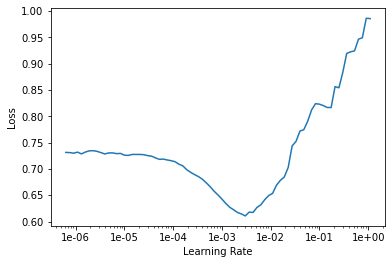

In [20]:
learn.recorder.plot()

In [21]:
learn = get_model_learner()
learn.fit_one_cycle(5, slice(1e-5,1e-3))#slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.554996,0.470043,0.781053,00:25
1,0.297957,0.380450,0.842105,00:24
2,0.189026,0.446970,0.825684,00:24
3,0.149350,0.386634,0.845895,00:24
4,0.115168,0.404818,0.845053,00:25


In [22]:
learn = get_model_learner()
learn.fit_one_cycle(10, slice(1e-5,1e-3))#slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.669222,0.603134,0.659790,00:25
1,0.432716,0.405177,0.839158,00:25
2,0.255557,0.388805,0.836632,00:24
3,0.181542,0.378362,0.850105,00:25
4,0.142584,0.432630,0.837474,00:24
5,0.126347,0.438615,0.829895,00:24
6,0.104178,0.409597,0.848421,00:24
7,0.079840,0.376394,0.851368,00:25
8,0.075346,0.373448,0.852632,00:25
9,0.076464,0.398080,0.851368,00:24


In [23]:
learn = get_model_learner()
learn.fit_one_cycle(15, slice(1e-5,1e-3))#slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.668642,0.626179,0.612211,00:24
1,0.474935,0.427883,0.829474,00:25
2,0.289705,0.351642,0.854316,00:24
3,0.200034,0.377719,0.853053,00:25
4,0.159963,0.442171,0.818105,00:25
5,0.140981,0.375517,0.860211,00:24
6,0.132472,0.459253,0.840421,00:24
7,0.109624,0.434629,0.844211,00:24
8,0.092997,0.397693,0.854737,00:24
9,0.082939,0.409582,0.842526,00:25
